# Comparing statsmodels to the casadi approach for Logistic Mixed Models

- 1 target
- 1 predictor
- 1 random intercept
- 1 random slope
- 1 "fixed" intercept

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import session_info
# import statsmodels
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# from jmspack.NLTSA import flatten
flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
import casadi as ca

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
# from scipy.stats import linregress
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [6]:
from pymer4 import Lmer

In [7]:
from sklearn.datasets import make_classification
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, confusion_matrix, auc

In [8]:
tmp = os.getcwd()
os.chdir(tmp.split("/playground")[0])

# from romeo.romeo import ROMEO
# from romeo.utils import formula_parser

os.chdir(tmp)

In [9]:
session_info.show(write_req_file=False)

# Statsmodels regularized mixedLM examples

In [10]:
data = sm.datasets.get_rdataset('dietox', 'geepack').data

In [11]:
# data_int = data.interpolate(method="linear", limit_direction="both")

# _ = plt.scatter(data_int["Time"], data_int["Feed"])
# _ = plt.scatter(data["Time"], data["Feed"])

In [12]:
# data=data.dropna()

In [13]:
data = data.assign(Weight_bin = (data["Weight"] > 40).astype(int))

In [14]:
data.head()

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time,Weight_bin
0,4601,Evit000,Cu000,1,26.500,26.500,nan,1,0
1,4601,Evit000,Cu000,1,26.500,27.600,5.200,2,0
2,4601,Evit000,Cu000,1,26.500,36.500,17.600,3,0
3,4601,Evit000,Cu000,1,26.500,40.300,28.500,4,1
4,4601,Evit000,Cu000,1,26.500,49.100,45.200,5,1


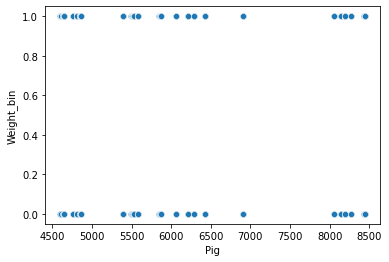

In [15]:
_ = sns.scatterplot(data=data, x="Pig", y="Weight_bin")

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pig         861 non-null    int64  
 1   Evit        861 non-null    object 
 2   Cu          861 non-null    object 
 3   Litter      861 non-null    int64  
 4   Start       861 non-null    float64
 5   Weight      861 non-null    float64
 6   Feed        789 non-null    float64
 7   Time        861 non-null    int64  
 8   Weight_bin  861 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 60.7+ KB


In [17]:
# md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
# mdf = md.fit(method=["lbfgs"])
# mdf.summary()

In [18]:
target = "Weight_bin"
fixed_effect = "Time"
grouping_var = "Pig"
random_slope = "Time"

In [19]:
{"target": "Weight_bin",
"fixed_effect": "Time",
"grouping_var": "Pig",
"random_slope": "Time"}

{'target': 'Weight_bin',
 'fixed_effect': 'Time',
 'grouping_var': 'Pig',
 'random_slope': 'Time'}

In [20]:
md = BinomialBayesMixedGLM.from_formula(formula=f"{target} ~ {fixed_effect}", 
                 data=data, 
#                  groups=data[grouping_var], 
                 vc_formulas={"a": random_slope}
                )
mdf = md.fit_vb()

In [21]:
mdf.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-6.4872,0.1558,,,
Time,M,1.7597,0.0406,,,
a,V,-1.3811,0.6685,0.251,0.066,0.957


In [22]:
# md = smf.mixedlm(f"{target} ~ {fixed_effect}", 
#                  data, 
#                  groups=data[grouping_var], 
#                  re_formula=f"~{random_slope}"
#                 )
# mdf = md.fit(method=["lbfgs"])
# mdf.summary()

In [23]:
mdf.params

array([-6.48716412,  1.75971008, -1.38105223, -0.04190831,  0.01136803])

In [24]:
fitted_real_values_df = pd.DataFrame({"y_pred": mdf.predict(data[[fixed_effect]]),
             target: data[target]})#.round(0)

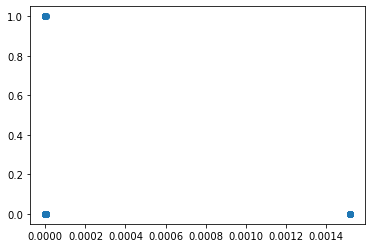

In [25]:
_ = plt.scatter(fitted_real_values_df["y_pred"], fitted_real_values_df[target])

In [26]:
# _ = plt.scatter(mdf.fittedvalues, data[target])

In [27]:
# mdf.fe_params

In [28]:
# import re

# formula_string = "Weight ~ Time + (1 + Time | Pig)"

# target = formula_string.replace(" ", "").split("~")[0]
# fixed_effect = formula_string.replace(" ", "").split("~")[1].split("+")[0]
# random_effects = re.findall("\((.*?)\)", formula_string)

# clusters = random_effects[0].replace(" ", "").split("+")[1].split("|")[1]

# {"target": target,
# "fixed_effect": fixed_effect,
# "random_effects": random_effects,
# "clusters": clusters}

# formula_parser(formula_string)

# Pymer4 version

In [29]:
formula_string = f"{target} ~ {fixed_effect} + (1 | {grouping_var}) + (0 + {random_slope} | {grouping_var} )"
formula_string

'Weight_bin ~ Time + (1 | Pig) + (0 + Time | Pig )'

In [145]:
mdp = Lmer(formula=formula_string, data=data, family='binomial')

In [146]:
mdp.fit(#conf_int="profile"#, control="optCtrl = list(ftol_abs=1, xtol_abs=1)"
    control="link = logit"
           )

RRuntimeError: Error in glmerControl(link = logit) : unused argument (link = logit)


In [32]:
mdp.fixef

,(Intercept),Time
4601,-83.088,23.750
4602,-83.088,23.750
4603,-83.088,23.750
4605,-73.725,26.433
4641,-73.725,26.433
...,...,...
8271,-83.088,23.750
8273,-83.088,23.750
8437,-83.088,23.750
8439,-83.088,23.750


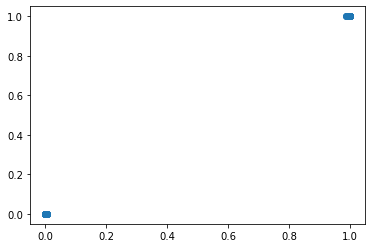

In [33]:
_ = plt.scatter(mdp.fits, data[target])

## Plot the fitted vs the real values

In [34]:
c_mat = confusion_matrix(data[target], mdp.fits.round(0))

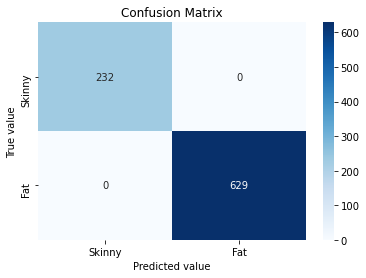

In [35]:
cmap='Blues'
categories=["Skinny", "Fat"]

_ = sns.heatmap(c_mat, 
                annot=True,            
                fmt="",
                cmap=cmap,
#                 cbar=cbar,
                xticklabels=categories,
                yticklabels=categories
               )
_ = plt.title("Confusion Matrix")
# _ = plt.xlabel(f'Predicted value\n\nAccuracy={summary_df["Accuracy"].values[0]}\nSensitivity={summary_df["Sensitivity"].values[0]}\nSpecificity={summary_df["Specificity"].values[0]}\nF1 Score={summary_df["F1"].values[0]}')
_ = plt.xlabel(f'Predicted value')
_ = plt.ylabel("True value")

In [36]:
fpr, tpr, thresh = roc_curve(y_true=data[target], y_score=mdp.fits, pos_label=1, sample_weight=None, drop_intermediate=False)

In [37]:
auc_score = roc_auc_score(y_true=data[target], y_score=mdp.fits)

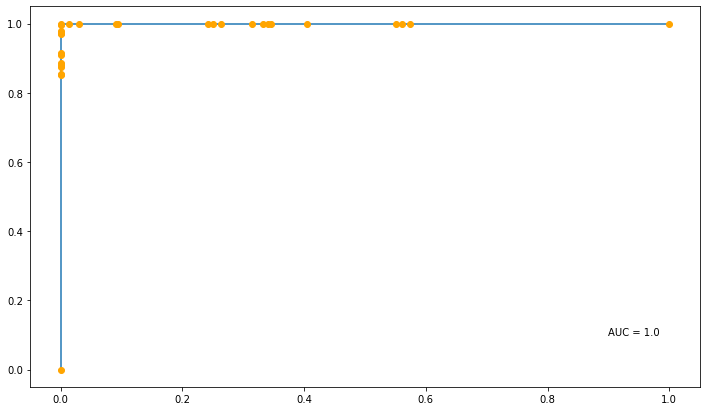

In [38]:
_ = plt.figure(figsize=(12, 7))
_ = plt.plot(fpr, 
             tpr, 
#              'o', 
            )
_ = plt.plot(fpr, 
             tpr, 
             'o',
             c="orange"
            )

_ = plt.annotate(text = f"AUC = {round(auc_score, 5)}",
                 xy=(0.9, 0.1),)

# LMM equation

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e00ba9a8e13237ca374d55bb3070aebd12a5b8e4" />

In [39]:
y = data[target]
y.head(2)

0    0
1    0
Name: Weight_bin, dtype: int64

In [40]:
x = data[[fixed_effect]]
x.head(2)

,Time
0,1
1,2


In [41]:
x = x.assign(intercept=1).set_index("intercept").reset_index()

In [42]:
u = data[grouping_var].unique()

In [43]:
u

array([4601, 4602, 4603, 4605, 4641, 4643, 4645, 4756, 4757, 4759, 4760,
       4813, 4814, 4815, 4817, 4854, 4856, 4857, 4858, 5389, 5392, 5497,
       5500, 5501, 5502, 5524, 5527, 5528, 5578, 5581, 5582, 5850, 5851,
       5852, 5862, 5865, 5866, 6055, 6056, 6057, 6058, 6207, 6208, 6211,
       6284, 6287, 6288, 6430, 6432, 6433, 6909, 6910, 6912, 8049, 8050,
       8051, 8053, 8139, 8141, 8142, 8144, 8191, 8192, 8193, 8195, 8269,
       8270, 8271, 8273, 8437, 8439, 8442])

In [44]:
len(u)

72

In [45]:
data[grouping_var]

0      4601
1      4601
2      4601
3      4601
4      4601
       ... 
856    8442
857    8442
858    8442
859    8442
860    8442
Name: Pig, Length: 861, dtype: int64

In [46]:
data[grouping_var].value_counts().sort_index()

4601    12
4602    12
4603    12
4605    12
4641    12
        ..
8271    12
8273    12
8437    12
8439    12
8442    12
Name: Pig, Length: 72, dtype: int64

In [47]:
data[grouping_var].value_counts().sort_values()

5528    11
5524    11
5527    11
8141    12
8139    12
        ..
6288    12
8437    12
8439    12
8271    12
4645    12
Name: Pig, Length: 72, dtype: int64

In [48]:
z_list = list()
for cluster_group in u:
    tmp = data.loc[data[grouping_var]==cluster_group, grouping_var]
#     print(cluster_group)

#     np.pad(tmp, (tmp.index.tolist()[0], data[clusters].shape[0] - tmp.index.tolist()[-1]+1))
    
    z_list.append(np.pad(tmp, (tmp.index.tolist()[0], data[grouping_var].shape[0] - tmp.index.tolist()[-1]+1)))

In [49]:
z_list[1].shape

(863,)

In [50]:
possible_Z_df = pd.DataFrame(np.vstack(z_list).T)#.head(50)

In [51]:
possible_Z_df

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,4601,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4601,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4601,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4601,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4601,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8442
859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8442
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8442
861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
binary_df = np.where(possible_Z_df > 0 , 1, possible_Z_df)

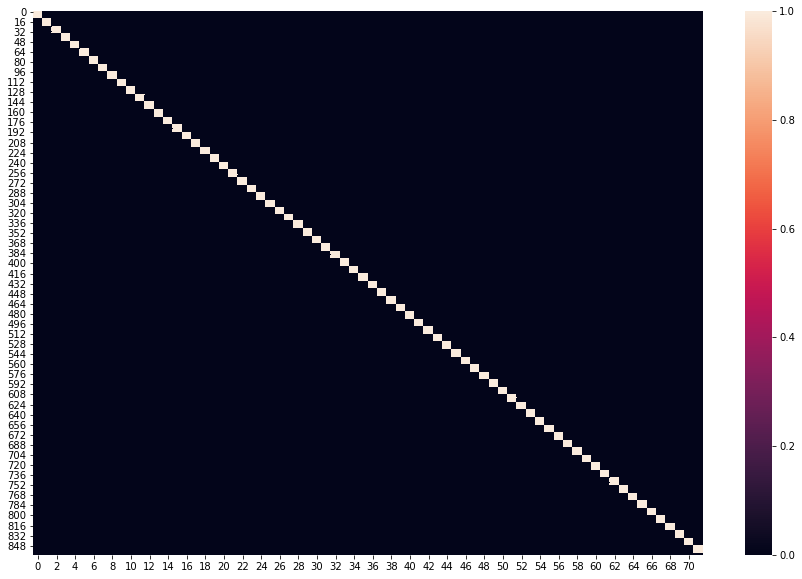

In [53]:
_ = plt.figure(figsize=(15, 10))
_ = sns.heatmap(binary_df)

In [54]:
# Z = possible_Z_df.loc[0: 860].values
Z = binary_df[0: 861]

In [55]:
Z

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e00ba9a8e13237ca374d55bb3070aebd12a5b8e4" />

In [56]:
x.shape, y.shape

((861, 2), (861,))

In [57]:
x.head()

,intercept,Time
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


In [58]:
x.shape

(861, 2)

In [59]:
Z.shape

(861, 72)

In [60]:
y.values.reshape(-1, 1).shape

(861, 1)

In [61]:
data[target] 

0      0
1      0
2      0
3      1
4      1
      ..
856    1
857    1
858    1
859    1
860    1
Name: Weight_bin, Length: 861, dtype: int64

In [62]:
z_list = list()
for cluster_group in u:
    tmp = data.loc[data[grouping_var]==cluster_group, random_slope]
#     print(cluster_group)

#     np.pad(tmp, (tmp.index.tolist()[0], data[clusters].shape[0] - tmp.index.tolist()[-1]+1))
    
    z_list.append(np.pad(tmp, (tmp.index.tolist()[0], data[grouping_var].shape[0] - tmp.index.tolist()[-1]+1)))

In [63]:
z_list[1].shape

(863,)

In [64]:
possible_Z_slope_df = pd.DataFrame(np.vstack(z_list).T)[0: 861]#.head(50)

In [65]:
Z

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

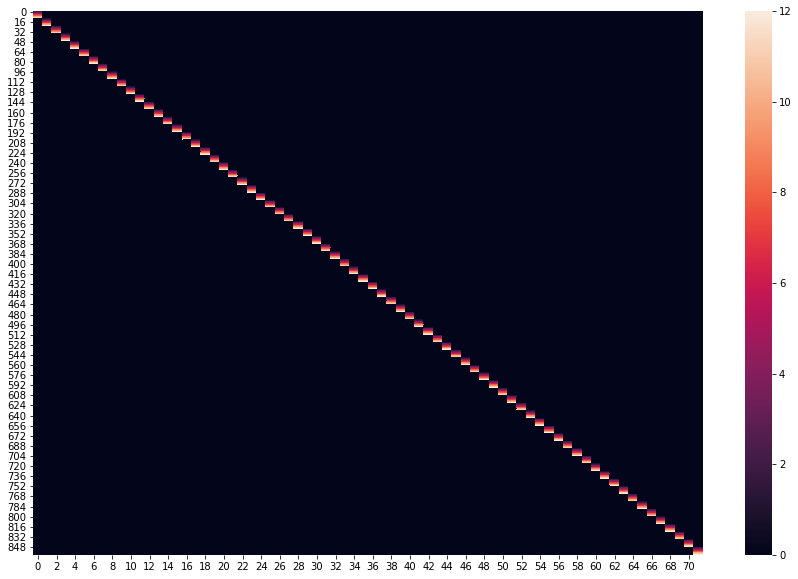

In [66]:
_ = plt.figure(figsize=(15, 10))
_ = sns.heatmap(possible_Z_slope_df)

In [67]:
Z.shape

(861, 72)

In [68]:
possible_Z_slope_df.values.shape

(861, 72)

In [69]:
def sigmoid(z):
    # Note it might be necessary to replace the np.exp with casadi version
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + ca.exp(-z))
    return s

In [70]:
def logit(z):
    """
    Compute the logit of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = z/ (1-z)
    return s

In [71]:
# ntheta = x.shape[1]
ntheta_fixed = 2 #(intercept, time,)
ntheta_random = 72 #(amount of pigs groups)
theta_fixed = ca.SX.sym("theta_fixed", ntheta_fixed)
# theta_random = ca.SX.sym("theta_random", ntheta_random)
theta_random = ca.SX.sym("theta_random", ntheta_random*2) # *2 because of random slope of time

alpha=1

model_method = "ols"

In [72]:
# model_lmm = ca.mtimes(x.values, theta_fixed) + ca.mtimes(Z, theta_random)

In [73]:
# model_fixed = ca.mtimes(x.values, theta_fixed) + ca.mtimes(Z_random_intercept, theta_random) + ca.mtimes(Z_random_slope, theta_random)

In [74]:
theta_random[0:ntheta_random].shape

(72, 1)

In [75]:
theta_random[ntheta_random:].shape

(72, 1)

In [76]:
model_lmm = ca.mtimes(x.values, theta_fixed) + ca.mtimes(Z, theta_random[0:ntheta_random]) + ca.mtimes(possible_Z_slope_df.values, theta_random[ntheta_random:])

In [77]:
(N, ntheta) = x.shape

In [78]:
# A = sigmoid(model_lmm)  # compute activation
A = logit(sigmoid(model_lmm))  # compute activation

# might be 1 / 2*N
cost = -1 / N * ca.sum1(y.values * ca.log(A) + (1 - y.values) * ca.log(1 - A))

In [79]:
# create optimization problem (x: optimization parameter, f: cost function)
nlp = {"x": ca.vertcat(theta_fixed, theta_random), "f": cost, }

# solve opt
solver = ca.nlpsol("ols", "ipopt", nlp)

In [80]:
len(np.zeros(ntheta_fixed + ntheta_random))

74

In [81]:
sol = solver(x0=np.zeros(ntheta_fixed + ntheta_random * 2))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      507

Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function computed!
Total number of variables............................:      146
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with

CasADi - 2021-12-08 15:53:47 WARNING("ols:nlp_grad_f failed: Inf detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-12-08 15:53:47 WARNING("ols:nlp_grad_f failed: Inf detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


In [82]:
# create residual
# e = y.values.reshape(-1, 1) - model_lmm

In [83]:
# ca.vertcat([ntheta_fixed, ntheta_random])
# ca.vertcat(theta_fixed, theta_random)

In [84]:
# # # create residual
# # e = y - ca.mtimes(x, theta)


# if model_method == "ols":
#     # create optimization problem (x: optimization parameter, f: cost function)
#     nlp = {"x": ca.vertcat(theta_fixed, theta_random), "f": 0.5 * ca.dot(e, e), }

# elif model_method == "lasso":
#     # CASE with regularization in cost function (LASSO)
#     nlp = {"x": ca.vertcat(theta_fixed, theta_random), "f": 0.5*ca.dot(e, e) + 0.5*alpha*ca.sum1(ca.fabs(theta_fixed))}

# else:
#     # CASE with regularization in cost function (RIDGE)
#     nlp = {"x": ca.vertcat(theta_fixed, theta_random), "f": 0.5*ca.dot(e, e) + 0.5*alpha*ca.dot(theta_fixed, theta_fixed)}

# # solve opt
# solver = ca.nlpsol("ols", "ipopt", nlp)
# # sol = solver(x0=np.zeros(ntheta_fixed + ntheta_random))
# sol = solver(x0=np.zeros(ntheta_fixed + ntheta_random*2))

In [85]:
theta_est = sol["x"]

# print(f"theta true: {coef}")
print(f"\ntheta comparison:\n {mdf.params}")
print(f"theta est: {theta_est}")


theta comparison:
 [-6.48716412  1.75971008 -1.38105223 -0.04190831  0.01136803]
theta est: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [86]:
results = flatten(theta_est.toarray().tolist())
np.array(results)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [87]:
intercept = results[0]
coefs = results[1]
intercept, coefs

(0.0, 0.0)

In [88]:
np.array(results[2:ntheta_random+2]) + results[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [89]:
ca_fixef = pd.DataFrame({"(Intercept)": np.array(results[2:ntheta_random+2]) + results[0],
              "Time": results[ntheta_random+2:]},
                       index=flatten(data[[grouping_var]].groupby(grouping_var).head(1).values.tolist()))
ca_fixef

,(Intercept),Time
4601,0.000,0.000
4602,0.000,0.000
4603,0.000,0.000
4605,0.000,0.000
4641,0.000,0.000
...,...,...
8271,0.000,0.000
8273,0.000,0.000
8437,0.000,0.000
8439,0.000,0.000


In [90]:
mdp.fixef

,(Intercept),Time
4601,-83.088,23.750
4602,-83.088,23.750
4603,-83.088,23.750
4605,-73.725,26.433
4641,-73.725,26.433
...,...,...
8271,-83.088,23.750
8273,-83.088,23.750
8437,-83.088,23.750
8439,-83.088,23.750


In [91]:
mdf.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-6.4872,0.1558,,,
Time,M,1.7597,0.0406,,,
a,V,-1.3811,0.6685,0.251,0.066,0.957


In [92]:
mdp.summary()

Formula: Weight_bin~Time+(1|Pig)+(0+Time|Pig)

Family: binomial	 Inference: parametric

Number of observations: 861	 Groups: {'Pig': 72.0}

Log-likelihood: -60.561 	 AIC: 129.121

Random effects:

              Name      Var    Std
Pig    (Intercept) 2479.294 49.793
Pig.1         Time  237.006 15.395

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-83.087,-99.738,-66.436,8.495,0.000,0.000,0.000,0.000,0.000,0.000,-9.780,0.000,***
Time,23.749,19.024,28.474,2.411,20601052026.702,182740283.940,2322439997661.138,1.000,1.000,1.000,9.851,0.000,***


In [93]:
len(Z)

861

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e00ba9a8e13237ca374d55bb3070aebd12a5b8e4" />

### `y = XB + Z*u + Z_s*u_s + E`

In [94]:
x

,intercept,Time
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
856,1,8
857,1,9
858,1,10
859,1,11


In [95]:
(N, ntheta) = x.shape

In [96]:
theta = ca.SX.sym("theta", ntheta)
X_sym = ca.SX.sym("X_sym", (N, ntheta))
y_sym = sigmoid(ca.mtimes(X_sym, theta))

In [97]:
y_sym.shape

(861, 1)

In [98]:
A = sigmoid(ca.mtimes(x.values, theta))  # compute activation

In [99]:
model = ca.Function("y_sym", [X_sym, theta_fixed, Z], [A])

RuntimeError: Error in Function::Function for 'y_sym' [SXFunction] at .../casadi/core/function.cpp:222:
.../casadi/core/function_internal.cpp:145: Error calling SXFunction::init for 'y_sym':
.../casadi/core/x_function.hpp:287: For y_sym: Xfunction input arguments must be purely symbolic.
Argument 2(i2) is not symbolic.

In [100]:
# ntheta = x.shape[1]
ntheta_fixed = 2 #(intercept, time,)
ntheta_random = 72 #(amount of pigs groups)
theta_fixed = ca.SX.sym("theta_fixed", ntheta_fixed)
# theta_random = ca.SX.sym("theta_random", ntheta_random)
theta_random = ca.SX.sym("theta_random", ntheta_random*2) # *2 because of random slope of time

X_sym = ca.SX.sym("X_sym", (N, ntheta_fixed))
Z_sym = ca.SX.sym("Z_sym", (N, ntheta_fixed))

alpha=1

model_method = "ols"

In [101]:
model_lmm = ca.mtimes(x.values, theta_fixed) + ca.mtimes(Z, theta_random[0:ntheta_random]) + ca.mtimes(possible_Z_slope_df.values, theta_random[ntheta_random:])

In [140]:
# model_lmm

In [103]:
x.shape

(861, 2)

In [104]:
theta.shape

(2, 1)

In [105]:
A.shape

(861, 1)

In [106]:
y.shape

(861,)

In [107]:
cost.shape

(1, 1)

In [108]:
# model(x.values, theta)

In [109]:
# fitted_values = np.array(model(x.values, cost))

# I am really not sure about this tbh

In [110]:
# x.assign(intercept=1).set_index("intercept").reset_index() * results[0:2]
# x * results[0]
# np.dot(Z, np.repeat(results[1:], repeats=12)[:-3].reshape(1,-1))
Zu = np.dot(Z, results[2:ntheta_random+2])
Z_s_u_s = np.dot(possible_Z_slope_df.values, results[ntheta_random+2:])

In [111]:
XB = x["intercept"] * results[0]

In [134]:
fitted_values = XB.add(pd.Series(Zu), axis=0).add(pd.Series(Z_s_u_s), axis=0)

In [138]:
XB.describe()

count   861.000
mean      0.000
std       0.000
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       0.000
Name: intercept, dtype: float64

In [113]:
# fitted_values = fitted_values.sum(axis=1)

In [114]:
def sigmoid(z):
    # Note it might be necessary to replace the np.exp with casadi version
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [115]:
fitted_values = sigmoid(fitted_values)
fitted_values

0     0.500
1     0.500
2     0.500
3     0.500
4     0.500
       ... 
856   0.500
857   0.500
858   0.500
859   0.500
860   0.500
Length: 861, dtype: float64

In [116]:
# _ = plt.scatter(mdf.fittedvalues, data[target])

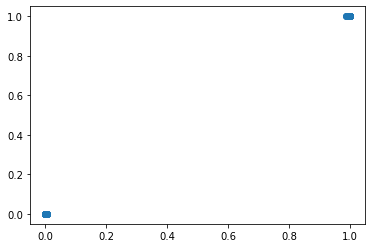

In [117]:
_ = plt.scatter(mdp.fits, data[target])

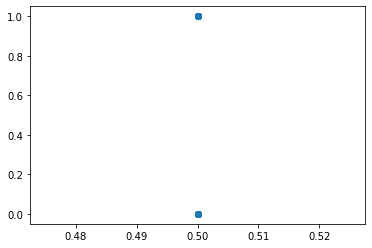

In [118]:
_ = plt.scatter(fitted_values, y)

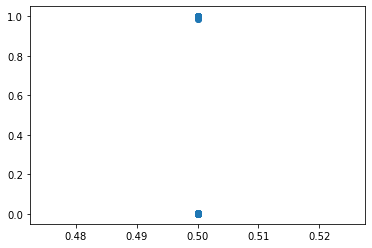

In [119]:
_ = plt.scatter(fitted_values, mdp.fits)

In [120]:
pred_target_df = pd.concat([fitted_values, y, data[grouping_var]], axis=1).rename(columns={0: "fitted", "Weight": "target"})

In [121]:
pred_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fitted      861 non-null    float64
 1   Weight_bin  861 non-null    int64  
 2   Pig         861 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 20.3 KB


In [122]:
pred_target_df[grouping_var] = pred_target_df[grouping_var].astype("category")

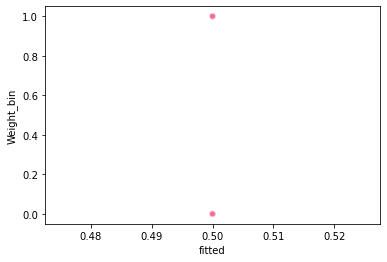

In [123]:
_ = sns.scatterplot(data=pred_target_df,
                   x="fitted",
                   y=target,
                   hue="Pig",
                   legend=False)

## Plot the fitted vs the real values

In [124]:
c_mat = confusion_matrix(data[target], pred_target_df["fitted"].round(0))

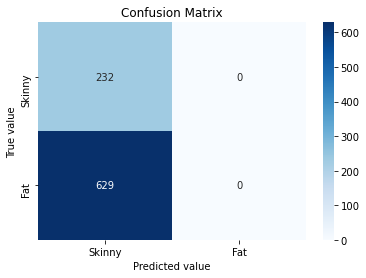

In [125]:
cmap='Blues'
categories=["Skinny", "Fat"]

_ = sns.heatmap(c_mat, 
                annot=True,            
                fmt="",
                cmap=cmap,
#                 cbar=cbar,
                xticklabels=categories,
                yticklabels=categories
               )
_ = plt.title("Confusion Matrix")
# _ = plt.xlabel(f'Predicted value\n\nAccuracy={summary_df["Accuracy"].values[0]}\nSensitivity={summary_df["Sensitivity"].values[0]}\nSpecificity={summary_df["Specificity"].values[0]}\nF1 Score={summary_df["F1"].values[0]}')
_ = plt.xlabel(f'Predicted value')
_ = plt.ylabel("True value")

In [126]:
pred_target_df

,fitted,Weight_bin,Pig
0,0.500,0,4601
1,0.500,0,4601
2,0.500,0,4601
3,0.500,1,4601
4,0.500,1,4601
...,...,...,...
856,0.500,1,8442
857,0.500,1,8442
858,0.500,1,8442
859,0.500,1,8442


In [127]:
fpr, tpr, thresh = roc_curve(y_true=data[target], y_score=pred_target_df["fitted"], pos_label=1, sample_weight=None, drop_intermediate=False)

In [128]:
# auc_score = roc_auc_score(y_true=data[target], y_score=pred_target_df["fitted"])

In [129]:
auc_score = auc(fpr, tpr)

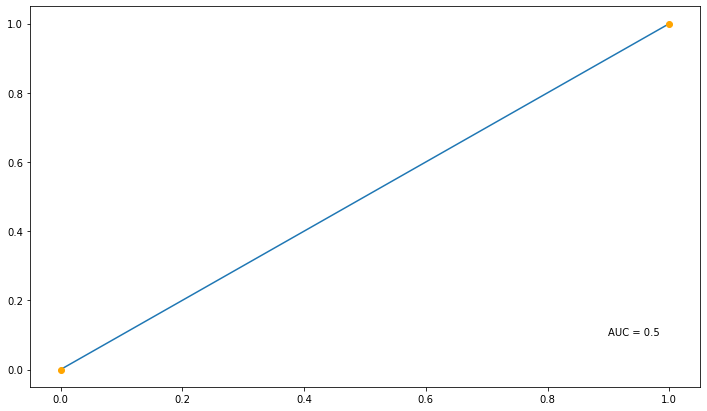

In [130]:
_ = plt.figure(figsize=(12, 7))
_ = plt.plot(fpr, 
             tpr, 
#              'o', 
            )
_ = plt.plot(fpr, 
             tpr, 
             'o',
             c="orange"
            )

_ = plt.annotate(text = f"AUC = {round(auc_score, 5)}",
                 xy=(0.9, 0.1),)

In [131]:
# order_of_estimates = fixed_intercept, fixed_coefficients, random_intercept, random_slope

In [132]:
len(results)

146

In [133]:
sol

{'f': DM(0),
 'g': DM([]),
 'lam_g': DM([]),
 'lam_p': DM([]),
 'lam_x': DM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'x': DM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}